In [1]:
using Pkg
Pkg.activate("..")
#Pkg.develop(["Equilibrium", "IMAS"])
using Revise
using FUSE
using FUSE.IMAS

  Activating environment at `~/.julia/dev/FUSE/Project.toml`


In [78]:
ϵ = 0.32
κ = 1.7
δ = 0.33
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0
x_point=true
symmetric=true

resolution = 129

eq0=IMAS.equilibrium()
FUSE.init(eq0, 0.0; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(eq0, 0.0, alpha=1, qstar=1.5,symmetric=symmetric)
@time FUSE.step(eqactor)
eq1 = FUSE.finalize(eqactor, resolution, (R0*(1-ϵ*1.5), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2))

println(eqactor.S)

eqt = eq1.time_slice[1];
# using Plots
# using Equilibrium
# Plots.plot(Equilibrium.boundary(eqactor.S).points,aspect=:equal)

  0.343225 seconds (5.82 M allocations: 321.391 MiB, 12.66% gc time)
SolovevEquilibrium
  B0 = 5.3 [T]
  R0 = 6.2 [m]
  ϵ  = 0.32
  δ  = 0.33
  κ  = 1.7
  α  = 0.0027856704762293967
  q⋆ = 1.5455268252174736
  βp = 0.8144205755686137
  βt = 0.03491367774697457
  σ  = 1
  diverted  = true
  xpoint  = (5.479808, -3.7100800000000005)
  symmetric = true


In [97]:
using Plots
import Plots:plot

function Plots.plot!(pf_active::IMAS.pf_active)
    Plots.plot!([c.element[1].geometry.rectangle.r for c in pf_active.coil],[c.element[1].geometry.rectangle.z for c in pf_active.coil],markershape=:rect,lw=0,label="",aspect=:equal)
end

function Plots.plot!(pfactor::PFcoilsOptActor, plot_trace=false)
    # plot mask
    rmask=pfactor.rmask
    zmask=pfactor.zmask
    dst=pfactor.mask_log_interpolant(zmask,rmask)
    plt=plot([NaN],[NaN],xlim=[rmask[1],rmask[end]],ylim=[zmask[1],zmask[end]],aspect_ratio=:equal,label="")
    contour!(rmask,zmask,dst,levels=[0.5],xlim=[rmask[1],rmask[end]],ylim=[zmask[1],zmask[end]], aspect_ratio=:equal,colorbar=false)
    
    # plot pf_active coils
    Plots.plot!(pfactor.pf_active)
    plot!(pfactor.eq_in.time_slice[1];label="Initial",lcfs=true, color=:black)
    plot!(pfactor.eq_out.time_slice[1];label="Final",color=:red)

    if plot_trace
        if length(pfactor.trace.coils)>0
            for c in 1:length(pfactor.trace.coils[1])
                plot!([FUSE.no_Dual(k[c][1]) for k in pfactor.trace.coils],[FUSE.no_Dual(k[c][2]) for k in pfactor.trace.coils],label="", lw=1, alpha=0.5)
            end
        end
    end
    return plt
end

function Plots.plot!(eqt::IMAS.equilibrium__time_slice; lcfs=false, kw...)
    if lcfs
        psi_levels=[eqt.global_quantities.psi_boundary,eqt.global_quantities.psi_boundary]
        psi_levels_out=[]
    else
        psi_levels=range(eqt.global_quantities.psi_axis,eqt.global_quantities.psi_boundary,length=11)
        psi_levels_out=(psi_levels[end]-psi_levels[1]).*collect(range(0,1,length=11)).+psi_levels[end]
    end

    kw_lcfs=(;kw...,:lw=>2)

    k=1
    primary=true
    for psi_level in vcat(psi_levels[2:end],psi_levels_out)
        for (pr,pz) in IMAS.flux_surface(eqt, psi_level, false)
            primary = k==1 ? true : false
            if psi_level == eqt.global_quantities.psi_boundary
                Plots.plot!(pr, pz; primary=primary, kw_lcfs...)
            else
                Plots.plot!(pr, pz; primary=primary,kw...)
            end
            k+=1
        end
    end
    Plots.plot!([eqt.global_quantities.magnetic_axis.r], [eqt.global_quantities.magnetic_axis.z];marker=:cross, primary=primary,kw...)
end


#===============#

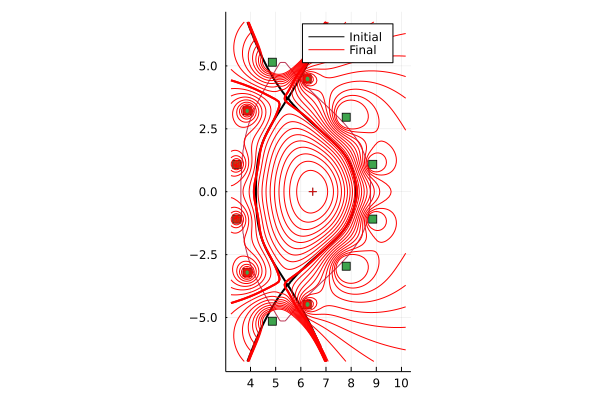

 * Status: failure (exceeded time limit of 30.0)

 * Candidate solution
    Final objective value:     2.356589e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit 30)
    Iterations:    5528
    f(x) calls:    8860



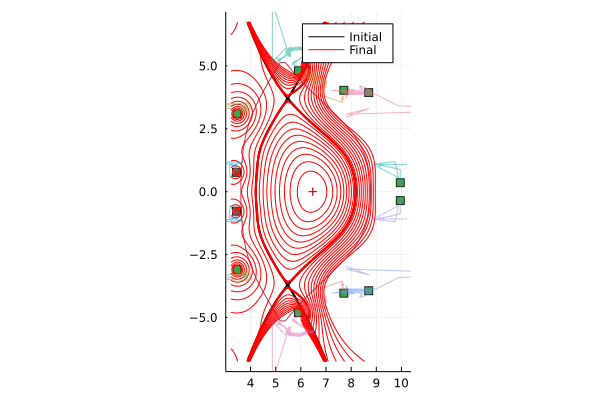

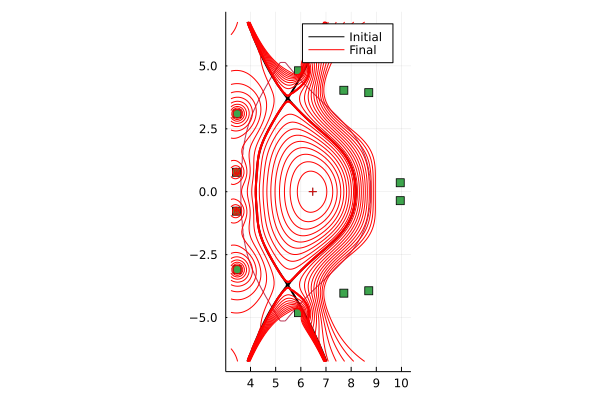

In [99]:
pfoptactor=PFcoilsOptActor(eq1,0.0, 12);

display(plot!(pfoptactor))

step(pfoptactor,λ_currents=1E6, verbose=true)

display(plot!(pfoptactor,true))
display(plot!(pfoptactor,false));
nothing

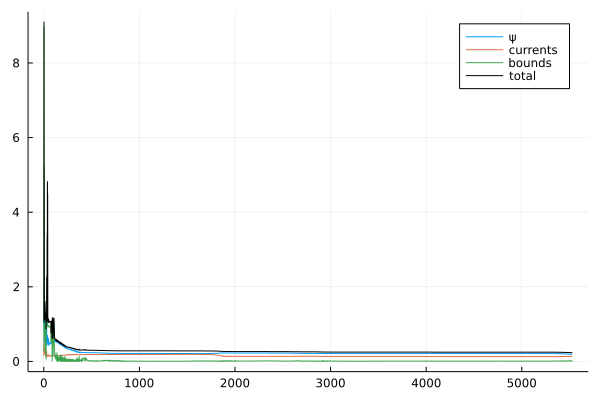

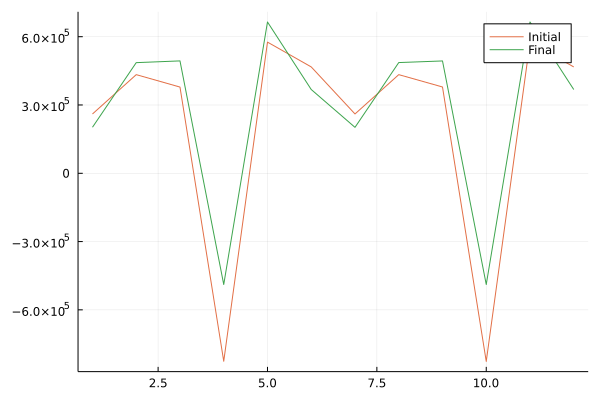

In [100]:
function Plots.plot!(trace::FUSE.PFcoilsOptTrace, start_at::Int=1, what::Symbol=:cost; kw...)
    x=(start_at:length(trace.cost))
    if what == :cost
        plot(x,[FUSE.no_Dual(y) for y in trace.cost_ψ[start_at:end]],label="ψ"; kw...)
        plot!(x,[FUSE.no_Dual(y) for y in trace.cost_currents[start_at:end]],label="currents"; kw...)
        plot!(x,[FUSE.no_Dual(y) for y in trace.cost_bound[start_at:end]],label="bounds"; kw...)
        plot!(x,[FUSE.no_Dual(y) for y in trace.cost[start_at:end]],label="total",color=:black; kw...)
    elseif what == :currents
        plot!([FUSE.no_Dual(y) for y in getfield(trace,what)[start_at:end]][1,:],label="Initial"; kw...)
        plot!([FUSE.no_Dual(y) for y in getfield(trace,what)[start_at:end]][end,:],label="Final"; kw...)
    else
        plot!(x,[FUSE.no_Dual(y) for y in getfield(trace,what)[start_at:end]],label=String(what); kw...)
    end
end

display(plot!(pfoptactor.trace,1,:cost))

plot([NaN],[NaN],label="")
display(plot!(pfoptactor.trace,1,:currents))
